# **Crowd Estimation Using Fastai V2**

The task is to estimate number of people in images taken inside a mall. 

State of the art solutions for this kind of problems are based on generating density maps using Unet-style convolutional neural networks. These density maps are then integrated to get the crowd estimation. 

However, for simplicity, we will do image regression. 

In this case, we don't generate density maps. Instead, we directy try to get an estimation of the crowd out of the network based on the features extracted from input images. 

In [1]:
!pip install git+git://github.com/fastai/fastai.git

  Cloning git://github.com/fastai/fastai.git to /tmp/pip-req-build-eu9ymwm6
     |████████████████████████████████| 5.9 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 748.8 MB 12 kB/s s eta 0:00:01   |█                               | 24.8 MB 8.0 MB/s eta 0:01:31     |█                               | 25.6 MB 10.5 MB/s eta 0:01:09     |███▏                            | 74.2 MB 7.8 MB/s eta 0:01:27     |████████▍                       | 197.1 MB 11.7 MB/s eta 0:00:48     |████████▌                       | 199.1 MB 11.7 MB/s eta 0:00:47     |████████▌                       | 199.8 MB 11.7 MB/s eta 0:00:47     |████████▋                       | 202.5 MB 473 kB/s eta 0:19:15     |█████████▉                      | 229.7 MB 10.2 MB/s eta 0:00:51     |█████████████▍                  | 313.7 MB 16.2 MB/s eta 0:00:27     |██████████████                  | 328.8 MB 13.8 MB/s eta 0:00:31     |██████████████▏                 | 330.6 MB 13.8 MB/s eta 0:00:31     |██████████████▎   

  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+35d732a
    Uninstalling torchvision-0.6.0a0+35d732a:
      Successfully uninstalled torchvision-0.6.0a0+35d732a
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you'll have torch 1.6.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np 
import pandas as pd 
import fastai
fastai.__version__

'2.0.2'

> Note: Until fastai version 2 becomes available on Kaggle you need to install it using the first cell. 

In [3]:
# import vision submodule from fastai
from fastai.vision.all import *

In [4]:
# path to directory of images
path = '/kaggle/input/crowd-counting/frames/frames/'

In [5]:
# sample of paths to input images
Path(path).ls()[:3]

(#3) [Path('/kaggle/input/crowd-counting/frames/frames/seq_000993.jpg'),Path('/kaggle/input/crowd-counting/frames/frames/seq_001132.jpg'),Path('/kaggle/input/crowd-counting/frames/frames/seq_000753.jpg')]

Notice that each image has a unique sequence number. 

Next, we a look at the provided labels.

In [6]:
df = pd.read_csv('/kaggle/input/crowd-counting/labels.csv')
df.head()

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


`id` in the above dataframe corresponds to the sequence number of an image.

Fastai expects as inputs the path to images and their corresponding labels.  

Hence, the dataframe will be updated to have all the required info. 

Path to images will be under col `x`, labels will be under col `y`.


In [7]:
df['id'] = df.id.apply(lambda x: '/kaggle/input/crowd-counting/frames/frames/seq_{:06d}.jpg'.format(x))
df.columns = ['x','y']
df.head()

,x,y
0,/kaggle/input/crowd-counting/frames/frames/seq_000001.jpg,35
1,/kaggle/input/crowd-counting/frames/frames/seq_000002.jpg,41
2,/kaggle/input/crowd-counting/frames/frames/seq_000003.jpg,41
3,/kaggle/input/crowd-counting/frames/frames/seq_000004.jpg,44
4,/kaggle/input/crowd-counting/frames/frames/seq_000005.jpg,41


Next we build the DataBlock. This defines types on input and out, how to obtain those, how to split the data, and finally specify trasformations to be applied. 

In [8]:
def get_x(df): return df['x'] # path to images
def get_y(df): return df['y'] # labels

d = DataBlock(blocks=(ImageBlock, RegressionBlock),    # types of input and output
         get_x = get_x,                                # function to get path to images
         get_y = get_y,                                # function fo get labels
         splitter=RandomSplitter(),                    # random splitter (20% for validation)
         item_tfms=Resize(224, ResizeMethod.Squish),)  # resize and squish images 

Build the data loaders using the DataBlock and the DataFrame.

In [9]:
dl = d.dataloaders(df)

Lengths of training and validation data sets

In [10]:
len(dl.train_ds), len(dl.valid_ds)

(1600, 400)

Show a batch of images along with their labels.

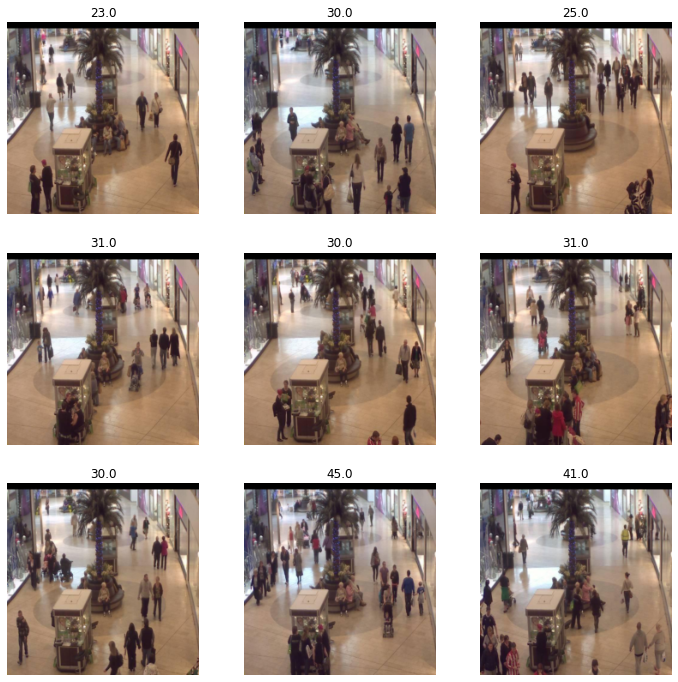

In [11]:
dl.show_batch(figsize=(12,12))

Build a Learner utilizing the Dataloaders, and using a pretrained `resnet18` model customized to prodcuce the required output (resression in this case) of crowd estimation.

In [13]:
learn = cnn_learner(dl, resnet18, metrics=mae)

In [14]:
learn.fine_tune(8, 5e-2)

epoch,train_loss,valid_loss,mae,time
0,598.951111,306.501862,15.050994,03:57


epoch,train_loss,valid_loss,mae,time
0,54.171963,48.468853,5.579992,05:06
1,38.764477,32.784195,4.490376,05:02
2,28.855406,13.210248,2.910785,05:04
3,22.002823,10.075722,2.559101,04:58
4,17.937624,5.404126,1.853608,04:58
5,15.076314,8.135451,2.297740,04:57
6,12.881441,3.927692,1.572159,05:03
7,11.066810,3.548269,1.478574,04:58


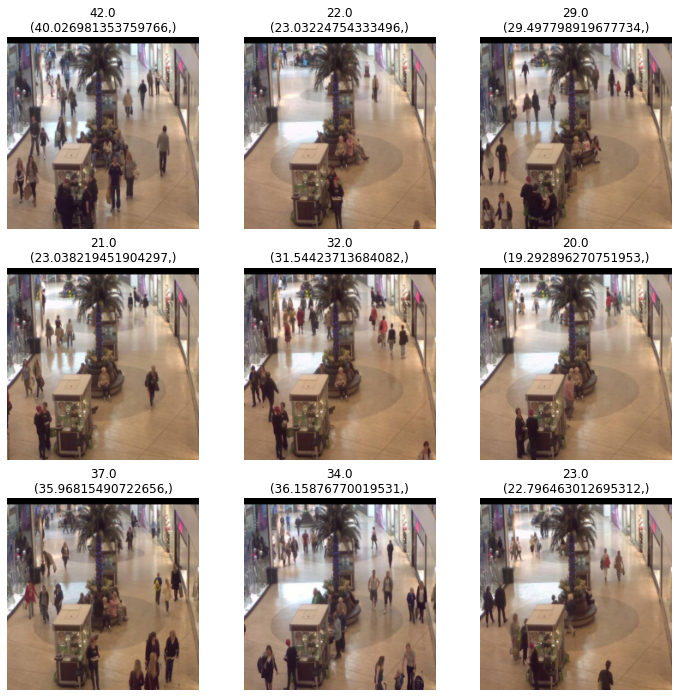

In [18]:
learn.show_results(figsize=(12,12))

We are able to obtain such a great result with just few lines of code!